```
This notebook sets up and runs a test case for analyzing Kelvin waves
Copyright (C) 2018 - 2022 SINTEF Digital
Copyright (C) 2018 - 2022 Norwegian Meteorological Institute

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [ ]:
import sys
gpuocean_path = [p[:-4] for p in sys.path if p.endswith("gpuocean/src")][0]
import git
repo = git.Repo(gpuocean_path)
print("GPUOcean code from:", repo.head.object.hexsha, "on branch", repo.active_branch.name)

# Oslofjord
Testing of Nils projected files

In [ ]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import datetime, copy
from IPython.display import display

#For plotting
import matplotlib
from matplotlib import pyplot as plt

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

In [ ]:
from gpuocean.utils import IPythonMagic, NetCDFInitialization

In [ ]:
%cuda_context_handler gpu_ctx

Path to the test file

In [ ]:
source_url = "/sintef/data/OsloFjord/test_polstere_1h_0007.nc"

## Inspecting file structure and content

In [ ]:
import xarray as xr
ds = xr.open_dataset(source_url)
ds

In [ ]:
from netCDF4 import Dataset
nc = Dataset(source_url)

H_m = np.ma.array(nc["h"][1:-1,1:-1], mask=(1-nc["mask_rho"][1:-1,1:-1]))

fig, ax = plt.subplots()
fig.suptitle("Bathymetry")

cmap = plt.cm.Blues
cmap.set_bad("grey", alpha = 1.0)
im = ax.imshow(H_m, cmap=cmap)

plt.colorbar(im, ax=ax)
plt.tight_layout()

Animation utils

In [ ]:
import animation_utils

## Generating GPUOcean Simulation from Input

In [ ]:
data_args = {}

In [ ]:
dimY, dimX = ds.h.data.shape

In [ ]:
x0, x1, y0, y1 = 5, dimX-5, 175, dimY-5

In [ ]:
import pyproj
proj_str = nc["projection"].proj4

proj = pyproj.Proj(proj_str)

lat_rho = nc.variables['lat_rho'][y0:y1, x0:x1]
lon_rho = nc.variables['lon_rho'][y0:y1, x0:x1]
x_rho, y_rho = proj(lon_rho, lat_rho, inverse = False)
x, y = x_rho[0], y_rho[:,0]

data_args['nx'] = (x1-x0)-4
data_args['ny'] = (y1-y0)-4

NX = data_args["nx"]+4
NY = data_args["ny"]+4

data_args['dx'] = np.average(x[1:] - x[:-1])
data_args['dy'] = np.average(y[1:] - y[:-1])

In [ ]:
data_args["dx"], data_args["dy"]

In [ ]:
data_args["t"] = np.float32(nc["ocean_time"][11].data)
print("Simulation start time = " + str(datetime.datetime.utcfromtimestamp(data_args["t"]).strftime('%Y-%m-%d %H:%M:%S')))

In [ ]:
data_args['angle'] = nc["angle"][y0:y1, x0:x1]
from gpuocean.utils import OceanographicUtilities
data_args['latitude'] = OceanographicUtilities.degToRad(lat_rho)
data_args["f"] = 0.0

Check Mixed-Layer Depth

In [ ]:
t=5*24 + 11 # INPUT

In [ ]:
mld = NetCDFInitialization.MLD(source_url, 1024, min_mld=1.5, max_mld=40, x0=x0, x1=x1, y0=y0, y1=y1, t=t)
backup_mld = copy.deepcopy(mld)

In [ ]:
# FIXME!!!
# mld = NetCDFInitialization.correct_coastal_MLD(mld, source_url, coords=[x0,x1,y0,y1], rel_tol=0.25, abs_tol=1, land_value=0.0)

mld = NetCDFInitialization.fill_coastal_data(mld)

#### Baroclinic model

In [ ]:
H = 0.0

In [ ]:
H_m_data = nc.variables['h'][y0-1:y1+1, x0-1:x1+1]
H_m_mask = (H_m_data == 0.0)
H_m = np.ma.array(H_m_data, mask=H_m_mask)
H_i = OceanographicUtilities.midpointsToIntersections(H_m, land_value=0.0, iterations=10)[0]

data_args["H"] = np.ma.array(H*np.ones_like(H_i), mask=H_i.mask.copy(), dtype=np.float32)

ML integrated data

In [ ]:
ml_integrator = NetCDFInitialization.MLD_integrator(source_url, mld, x0=x0, x1=x1, y0=y0, y1=y1)

In [ ]:
nc = Dataset(source_url)
u0 = nc.variables['u'][t, :, y0:y1, x0:x1+1]
v0 = nc.variables['v'][t, :, y0:y1+1, x0:x1]
#Find u,v at cell centers
u0 = u0.filled(fill_value = 0.0)
v0 = v0.filled(fill_value = 0.0)

u0 = (u0[:, :,1:] + u0[:, :, :-1]) * 0.5
v0 = (v0[:, 1:,:] + v0[:, :-1, :]) * 0.5

data_args["eta0"] = mld
data_args["hu0"] = np.sum(ml_integrator * u0, axis=0)
data_args["hv0"] = np.sum(ml_integrator * v0, axis=0)

In [ ]:
s_pot_densities = NetCDFInitialization.potentialDensities(source_url, t=t, x0=x0, x1=x1, y0=y0, y1=y1)
ml_pot_density = np.average(np.sum(ml_integrator * s_pot_densities, axis=0)/np.sum(ml_integrator, axis=0)) #NOTE: np.sum(integrator, axis=0)) = mld

inverse_integrator = np.ma.array(np.ones_like(ml_integrator), mask=ml_integrator.mask.copy()) - ml_integrator
deep_pot_density  = np.average(np.sum(inverse_integrator * s_pot_densities, axis=0)/np.sum(inverse_integrator, axis=0))

eps = (deep_pot_density - ml_pot_density)/deep_pot_density

data_args["g"] = eps * 9.81
data_args["g"]

Artifical data

In [ ]:
mld = np.ma.array( 10.0*np.ones_like(mld), mask=copy.copy(mld.mask) )

data_args["eta0"] = np.ma.array(mld.data - H, mask=copy.copy(mld.mask))

In [50]:
init_mld_south = 2.5
init_mld_north = 7.5

mld.data[0:430] = init_mld_south*np.ones((430,mld.shape[1])) + (init_mld_north - init_mld_south)*np.ones((430,mld.shape[1]))*np.arange(0,1,1/430)[:,np.newaxis]
mld.data[430:] = init_mld_north
mld.data[:,235:] = init_mld_north
mld = NetCDFInitialization.fill_coastal_data(mld)

data_args["eta0"] = np.ma.array(mld.data - H, mask=copy.copy(mld.mask))

In [ ]:
# Starting from lake at rest
data_args["hu0"] = np.ma.array(np.zeros_like(mld), mask=copy.copy(mld.mask))
data_args["hv0"] = np.ma.array(np.zeros_like(mld), mask=copy.copy(mld.mask))

In [ ]:
data_args["g"] = 0.01

In [ ]:
data_args["r"] = 3.0e-3

Set-up osciallating BC

In [ ]:
T = 5*24*3600  #Input

In [ ]:
from gpuocean.utils import Common

In [ ]:
data_args['boundary_conditions'] = Common.BoundaryConditions(north=3, south=3, east=3, west=3, spongeCells={'north':20, 'south': 20, 'east': 20, 'west': 20})

In [ ]:
plt.plot(np.arange(0,mld.shape[1]),mld[0].filled(0.0))
plt.axvline(x=165, c="red")

In [ ]:
t_step = 3600
T_steps = int(np.ceil(T/t_step)+1)

ts = data_args["t"] + np.arange(0, T+1, step=t_step)

In [ ]:
ampl_v = 0.3 #Input
freq = 12*3600 
bc_v_ref = ampl_v * np.cos(2*np.pi*ts/freq)[:,np.newaxis] 

bc_v = np.zeros((T_steps, NX))
bc_v[:,165:] = np.ones((T_steps, NX-165)) * bc_v_ref

In [ ]:
plt.title("current forcing from the south boundary")
plt.plot(((ts-ts[0])/3600),bc_v[:,170])
plt.xlabel("time [h]")
plt.ylabel("u [m^2/s]")

In [ ]:
bc_h = mld[0].data*np.ones((T_steps,NX)) #np.tile(mld[0], (T_steps,1))

ampl_h = 3.0
bc_h[:,165:] = bc_h[:,165:] + ampl_h*np.ones_like(bc_h[:,165:])*np.cos(2*np.pi*ts/freq)[:,np.newaxis]

bc_hv = bc_h*bc_v

bc_h = bc_h - H

south = Common.SingleBoundaryConditionData(h=bc_h.astype(np.float32), hu=np.zeros((T_steps, NX), dtype=np.float32), hv=bc_hv.astype(np.float32))
north = Common.SingleBoundaryConditionData(h=np.zeros((T_steps, NX), dtype=np.float32), hu=np.zeros((T_steps, NX), dtype=np.float32), hv=np.zeros((T_steps, NX), dtype=np.float32))
east  = Common.SingleBoundaryConditionData(h=np.zeros((T_steps, NY), dtype=np.float32), hu=np.zeros((T_steps, NY), dtype=np.float32), hv=np.zeros((T_steps, NY), dtype=np.float32))
west  = Common.SingleBoundaryConditionData(h=np.zeros((T_steps, NY), dtype=np.float32), hu=np.zeros((T_steps, NY), dtype=np.float32), hv=np.zeros((T_steps, NY), dtype=np.float32))

data_args["boundary_conditions_data"] = Common.BoundaryConditionsData(ts, north=north, south=south, east=east, west=west)

Wind forcing

In [ ]:
wind_u_ref = np.zeros(24)
wind_u_ref[:10] = -0.5*(np.sin(2*np.pi*(np.arange(0,10)-2.5)/10)+1)
wind_u_ref[10:] = 5*(np.sin(2*np.pi*(np.arange(10,24)+0.5)/14)+1)

plt.title("Wind in y-direction")
plt.plot(wind_u_ref)
plt.xlabel("hours in day")
plt.ylabel("wind speed [m/s]")

In [ ]:
wind_angle = np.deg2rad(45.0)

wind_u = (np.int32(np.ceil((T_steps)/24)) * list(np.cos(wind_angle)*wind_u_ref[:,np.newaxis][:,np.newaxis].astype(np.float32)))[0:len(ts)]
wind_v = (len(wind_u) *list(np.sin(wind_angle)*wind_u_ref[:,np.newaxis][:,np.newaxis].astype(np.float32)))[0:len(ts)]

In [ ]:
from gpuocean.utils import WindStress
wind = WindStress.WindStress(t=ts, wind_u=wind_v, wind_v=wind_u)
wind.compute_wind_stress_from_wind()

New Wind Stress?

In [ ]:
# zref  = 10.0
# kappa = 0.4 #https://en.wikipedia.org/wiki/Von_K%C3%A1rm%C3%A1n_constant
# z0min = 1.5e-5
# beta  = 0.018
# g     = 0.01
# rhoa  = 1.2923 # Reference density of dry air
# B     = beta/g
# taux  = []
# tauy  = []

# CORR = 0.1
# print("THE WIND SPEEDS WERE SCALED BY ", CORR)

# for i in range(0,len(wind_u)):
#     vind   = ( np.array(CORR*wind_u[i])**2 + np.array(CORR*wind_v[i])**2)**0.5
#     us2    = np.ones_like(vind)*0.1
#     z0     = np.ones((2,vind.shape[0],vind.shape[1]),dtype=np.float32)*z0min
#     us2min = 1e-3
#     us2old = us2*0.0
#     n = 0
#     while ( max( abs(np.min(us2 - us2old)),abs(np.max( us2 - us2old ))) > us2min):
#         n+=1
#         us2old    = us2
#         z0[0,:,:] = B*us2
#         us2       = ((kappa*vind)/(np.log(zref/np.max(z0,0))))**2
#     vind = np.where(vind<0.1, 0.1, vind)
#     #
#     taux.append(rhoa*us2*np.array(CORR*wind_u[i])/vind)
#     tauy.append(rhoa*us2*np.array(CORR*wind_v[i])[:,:]/vind)

In [ ]:
# plt.plot(np.array(wind.stress_v).flatten()[0:24], label="gpuocean")
# plt.plot(np.array(taux).flatten()[0:24], label="Hiram - wrong scaling?")
# plt.title("Wind Stress from wind")
# plt.legend(labelcolor="black")


In [ ]:
from gpuocean.utils import WindStress
data_args["wind"] = WindStress.WindStress(t=[0],stress_u=[np.array([[0.0]], dtype=np.float32)],stress_v=[np.array([[0.0]], dtype=np.float32)])

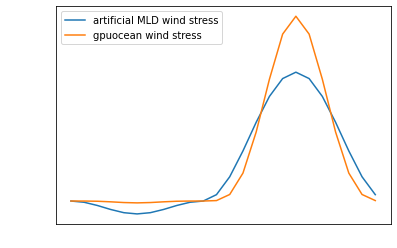

In [55]:
wind_scaling = 1e-5

wind_stress_u = copy.deepcopy(wind_u)
wind_stress_v = copy.deepcopy(wind_v)
for t_idx in range(len(wind_stress_u)):
    wind_stress_u[t_idx] = wind_scaling*wind_stress_u[t_idx]
    wind_stress_v[t_idx] = wind_scaling*wind_stress_v[t_idx]

data_args["wind"] = WindStress.WindStress(t=ts, stress_u=wind_stress_v, stress_v=wind_stress_u)

plt.plot(np.array(wind_stress_u).flatten()[0:24], label="artificial MLD wind stress")
plt.plot(np.array(wind.stress_v).flatten()[0:24], label="gpuocean wind stress")
plt.legend(labelcolor="black")

Run simulation

In [56]:
from gpuocean.SWEsimulators import CDKLM16
sim = CDKLM16.CDKLM16(gpu_ctx, dt=0.0,  **NetCDFInitialization.removeMetadata(data_args), write_netcdf=True)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


Closing file /home/florianb/havvarsel/reduced-gravity-ocean-model/notebooks/Oslofjord/netcdf_2023_01_13/CDKLM16_2023_01_13-10_32_35.nc ...


In [57]:
subt = 3600
for runt in range(int(T/subt)):#range(len(ds.ocean_time)):
    sim.step(subt)

if runt*subt > T:
    print("Boundary conditions too short!")

In [59]:
with plt.rc_context({'lines.color':'black', 
                        'text.color':'black', 
                        'axes.labelcolor':'black', 
                        'xtick.color':'black',
                        'ytick.color':'black'}):
    anim = animation_utils.ncAnimation(sim.sim_writer.output_file_name, "gpuocean-reduced_grav", comment="GPUOcean")
    anim.save("anims/GPUOceanSimulation-latest.mp4")

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/numpy/ma/core.py:1158: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/numpy/ma/core.py:1015: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)


In [ ]:
# with plt.rc_context({'lines.color':'black', 
#                         'text.color':'black', 
#                         'axes.labelcolor':'black', 
#                         'xtick.color':'black',
#                         'ytick.color':'black'}):
#     anim = animation_utils.ncAnimation(sim.sim_writer.output_file_name, "gpuocean-reduced_grav", comment="GPUOcean")
#     anim.save("anims/GPUOceanSimulation-FjordOSInit+all.mp4")

In [ ]:
sim.g